# Check for gradient of A/C/G/T additions

## Imports

In [1]:
import os
import gzip
import numpy as np
import pandas as pd
from scipy import stats
import re
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from turtles.turtles_utils import clr
from Bio import pairwise2, SeqIO

In [2]:
sns.set(style='whitegrid', font_scale=2)

## Set Parameters

In [3]:
base_path = '/mnt/c/Users/jonst/Northwestern University/Tyo Lab - Shared group resources' \
            '/Publications Presentations & Proposals from Group/Manuscripts' \
            '/2022 - Callisto Strutz - tdt data storage'

data_dir = base_path + '/01 Raw data/dNTP_addition_1/'

figure_dir = base_path + '/02 Analyzed data/preliminary_figures/dNTP_changes/'

# hgRNA sequences
hgRNA_dict = {'A21': 'GTCCCCTCCACCCCACA',
              'D21': 'GTCACGCTACGGCCAAG',
              'E21': 'GTTCCAGAGATACTGAC'}

In [4]:
def get_replicate(filename):
    rep = int(filename.split('-')[-1].split('_')[0])
    return rep

Note that No TdT replicates are taken from ca_camm_1 experiment

In [5]:
filenames = []
timepoints = []
tdts = []
controls = []
control_conds = []
reps = []
concs = []

for folder in os.listdir(data_dir):
    for fastq_filename in os.listdir(os.path.join(data_dir, folder)):
        if fastq_filename.endswith('R1_001.fastq.gz'):
            if 'STOP' in fastq_filename:
                tdt = False
            else:
                tdt = True
            
            if '0-CA-' in fastq_filename or '0-CTGA' in fastq_filename:
                control = True
            else:
                control = False
                
            if '-dC-' in fastq_filename or '-dG-' in fastq_filename or '-dT-' in fastq_filename or '-CTGA-' in fastq_filename:
                control_cond = 'CTG'
            elif 'STOP' in fastq_filename:
                control_cond = 'n/a'
            else:
                control_cond = 'A'

            timepoint = 72  # all have 72 hr timepoint for this run
            
            if '0-5mM-' in fastq_filename:
                conc = '0.5 mM'
            elif '100uM' in fastq_filename:
                conc = '100 uM'
            elif '10mM' in fastq_filename:
                conc = '10 mM'
            elif '1mM' in fastq_filename:
                conc = '1 mM'
            elif '1uM' in fastq_filename:
                conc = '1 uM'
            elif '30uM' in fastq_filename:
                conc = '30 uM'
            elif '3uM' in fastq_filename:
                conc = '3 uM'
            elif '5mM' in fastq_filename:
                conc = '5 mM'
            elif 'T-dA' in fastq_filename:
                conc = '20 uM'
            else:
                conc = '0'

            rep = get_replicate(fastq_filename)

            filenames.append(fastq_filename.replace('_L001_R1_001.fastq.gz', ''))
            timepoints.append(timepoint)
            tdts.append(tdt)
            controls.append(control)
            reps.append(rep)
            control_conds.append(control_cond)
            concs.append(conc)
        elif not fastq_filename.endswith('R2_001.fastq.gz'):
            print(f'No R1 file for {fastq_filename}')

In [6]:
summary_df = pd.DataFrame()
summary_df['Filename'] = filenames
summary_df['Timepoint'] = timepoints
summary_df['TdT'] = tdts
summary_df['Control'] = controls
summary_df['Control Condition'] = control_conds
summary_df['Replicate'] = reps
summary_df['Concentration'] = concs
summary_df

,Filename,Timepoint,TdT,Control,Control Condition,Replicate,Concentration
0,0-5mM-dT-1_S38,72,True,False,CTG,1,0.5 mM
1,0-5mM-dT-2_S41,72,True,False,CTG,2,0.5 mM
2,0-5mM-dT-3_S44,72,True,False,CTG,3,0.5 mM
3,0-CA-1_S3,72,True,True,A,1,0
4,0-CA-2_S7,72,True,True,A,2,0
5,0-CA-3_S11,72,True,True,A,3,0
6,0-CTGA-1_S26,72,True,True,CTG,1,0
7,0-CTGA-2_S30,72,True,True,CTG,2,0
8,0-CTGA-3_S34,72,True,True,CTG,3,0
9,100uM-CA-1_S39,72,True,False,A,1,100 uM


## Load Data and Parse TdT-synthesized Part

In [7]:
# No barcodes

seqs = {}
hgRNAs = {}
n_cut_list = []
n_seqs_list = []
ave_lens = []

for fastq_dir in os.listdir(data_dir):
    for fastq_filename in os.listdir(os.path.join(data_dir, fastq_dir)):

        if fastq_filename.endswith('R1_001.fastq.gz'):
            n_seqs = 0
            n_cut = 0
            lengths = []
            condition_name = fastq_filename.replace('_L001_R1_001.fastq.gz', '')
            seqs[condition_name] = []
            hgRNAs[condition_name] = []
            i = 0
            with gzip.open(os.path.join(data_dir, fastq_dir, fastq_filename), "rt") as fastq_file:
                for fasta in SeqIO.parse(fastq_file, format='fastq'):
                    seq = str(fasta.seq)

                    for key, hgRNA in hgRNA_dict.items():
                        hgRNA_index = seq.find(hgRNA)

                        if hgRNA_index != -1:
                            seq = seq[(hgRNA_index + len(hgRNA)):]

                            # Find GTGGGGTTAGA, cut site is just before that
                            pos = str(seq).find('GTGGGGTTAGA')

                            if pos == -1:  # i.e. not found
                                continue
                            else:
                                seq = seq[:pos]
                                if seq:
                                    i += 1
                                    hgRNAs[condition_name].append(key)
                                    seqs[condition_name].append(seq)
                                    n_cut += 1
                                    lengths.append(len(seq))
                                else:
                                    lengths.append(0)
                    n_seqs += 1
                print('\nRead', str(n_seqs), 'sequences in', fastq_filename, '...')
                print('Number cut and inserted into:', n_cut)
                ave_len = round(np.mean(lengths), 2)
                print(f'Average length (including 0-length seqs): {ave_len}\n')
                n_seqs_list.append(n_seqs)
                n_cut_list.append(n_cut)
                ave_lens.append(ave_len)


Read 156833 sequences in 0-5mM-dT-1_S38_L001_R1_001.fastq.gz ...
Number cut and inserted into: 42593
Average length (including 0-length seqs): 1.58


Read 189029 sequences in 0-5mM-dT-2_S41_L001_R1_001.fastq.gz ...
Number cut and inserted into: 51707
Average length (including 0-length seqs): 1.63


Read 123903 sequences in 0-5mM-dT-3_S44_L001_R1_001.fastq.gz ...
Number cut and inserted into: 33202
Average length (including 0-length seqs): 1.52


Read 114270 sequences in 0-CA-1_S3_L001_R1_001.fastq.gz ...
Number cut and inserted into: 26941
Average length (including 0-length seqs): 1.2


Read 152376 sequences in 0-CA-2_S7_L001_R1_001.fastq.gz ...
Number cut and inserted into: 33483
Average length (including 0-length seqs): 1.07


Read 134184 sequences in 0-CA-3_S11_L001_R1_001.fastq.gz ...
Number cut and inserted into: 31420
Average length (including 0-length seqs): 1.17


Read 180144 sequences in 0-CTGA-1_S26_L001_R1_001.fastq.gz ...
Number cut and inserted into: 35031
Average length 

In [8]:
conds = []

for filename in summary_df.Filename:
    if '-dT-' in filename:
        cond = 'T'
    elif '-dA' in filename:
        cond = 'dCF-dAdo-A'
    elif '-dC-' in filename:
        cond = 'C'
    elif '-dG-' in filename:
        cond = 'G'
    elif '-dCF-' in filename:
        cond = 'dCF'
    elif '-CA-' in filename:
        cond = 'dCF-dAdo'
    elif '-CTGA-' in filename:
        cond = 'none'
    elif 'STOP' in filename:
        cond = '-TdT'
    else:
        raise ValueError(f'{filename} not recognized.')
    
    conds.append(cond)

In [9]:
summary_df['# Seqs'] = n_seqs_list
summary_df['# Cuts'] = n_cut_list
summary_df['Average Length'] = ave_lens
summary_df['Condition'] = conds
summary_df.head()

,Filename,Timepoint,TdT,Control,Control Condition,Replicate,Concentration,# Seqs,# Cuts,Average Length,Condition
0,0-5mM-dT-1_S38,72,True,False,CTG,1,0.5 mM,156833,42593,1.58,T
1,0-5mM-dT-2_S41,72,True,False,CTG,2,0.5 mM,189029,51707,1.63,T
2,0-5mM-dT-3_S44,72,True,False,CTG,3,0.5 mM,123903,33202,1.52,T
3,0-CA-1_S3,72,True,True,A,1,0,114270,26941,1.20,dCF-dAdo
4,0-CA-2_S7,72,True,True,A,2,0,152376,33483,1.07,dCF-dAdo


## Format into DataFrames

In [10]:
seq_dfs = []
for filename in filenames:
    seq_df = pd.DataFrame()
    seq_df['Sequence'] = seqs[filename]
    seq_df['hgRNA'] = hgRNAs[filename]
    seq_df['Filename'] = filename
    seq_dfs.append(seq_df)

In [11]:
seq_dfs[1].head()

,Sequence,hgRNA,Filename
0,A,E21,0-5mM-dT-2_S41
1,CA,D21,0-5mM-dT-2_S41
2,GGA,A21,0-5mM-dT-2_S41
3,CA,D21,0-5mM-dT-2_S41
4,G,D21,0-5mM-dT-2_S41


In [12]:
for df in seq_dfs:
    if df['Sequence'].any():
        lengths = df.apply(lambda x: len(x['Sequence']), axis=1)
        df['Length'] = lengths

### Count A, C, G, T bases

In [13]:
def count_bases(seq, base):
    count = seq.count(base)
    return count

In [14]:
for df in seq_dfs:
    if len(df) == 0:
        continue

    # Count A, C, G, T
    for base in ['A', 'C', 'G', 'T']:
        df[base] = df.apply(lambda x: count_bases(x['Sequence'], base), axis=1)

In [15]:
seq_dfs[1].head()

,Sequence,hgRNA,Filename,Length,A,C,G,T
0,A,E21,0-5mM-dT-2_S41,1,1,0,0,0
1,CA,D21,0-5mM-dT-2_S41,2,1,1,0,0
2,GGA,A21,0-5mM-dT-2_S41,3,1,0,2,0
3,CA,D21,0-5mM-dT-2_S41,2,1,1,0,0
4,G,D21,0-5mM-dT-2_S41,1,0,0,1,0


## Calculate overall A, C, G, T for each file

In [16]:
totals_a = []
totals_c = []
totals_g = []
totals_t = []
totals_len = []

for i, df in enumerate(seq_dfs):

    if len(df) == 0:
        total_a = 0
        total_c = 0
        total_g = 0
        total_t = 0
    else:
        filename = filenames[i]
        total_a = df.A.sum()
        total_c = df.C.sum()
        total_g = df.G.sum()
        total_t = df['T'].sum()  # T can mean transpose

    avg_len = (total_a + total_c + total_g + total_t) / len(df)
        
    totals_a.append(total_a)
    totals_c.append(total_c)
    totals_g.append(total_g)
    totals_t.append(total_t)
    totals_len.append(avg_len)

In [17]:
summary_df['A'] = totals_a
summary_df['C'] = totals_c
summary_df['G'] = totals_g
summary_df['T'] = totals_t
summary_df['Mean Insert Length'] = totals_len

In [18]:
summary_df.head()

,Filename,Timepoint,TdT,Control,Control Condition,Replicate,Concentration,# Seqs,# Cuts,Average Length,Condition,A,C,G,T,Mean Insert Length
0,0-5mM-dT-1_S38,72,True,False,CTG,1,0.5 mM,156833,42593,1.58,T,32992,50066,54352,24624,3.804240
1,0-5mM-dT-2_S41,72,True,False,CTG,2,0.5 mM,189029,51707,1.63,T,40423,60141,67513,30299,3.836541
2,0-5mM-dT-3_S44,72,True,False,CTG,3,0.5 mM,123903,33202,1.52,T,24412,38084,41988,18578,3.706463
3,0-CA-1_S3,72,True,True,A,1,0,114270,26941,1.20,dCF-dAdo,13226,32632,35508,9645,3.378160
4,0-CA-2_S7,72,True,True,A,2,0,152376,33483,1.07,dCF-dAdo,16164,38277,44846,12216,3.330138


## Calculate % A, C, G, T and Plot

In [19]:
def calc_count_pcts(counts):
    total = sum(counts)
    if total == 0:
        total = 1  # avoid divide by zero errors and make all values 0%
    pcts = [100 * count / total for count in counts]
    return pd.Series(pcts)

In [20]:
pct_df = summary_df.apply(lambda x: calc_count_pcts([x['A'], x['C'], x['G'], x['T']]), axis=1)
pct_df.columns = ['A%', 'C%', 'G%', 'T%']

In [21]:
summary_df_new = pd.concat([summary_df, pct_df], axis=1)
rep_df = summary_df_new.apply(lambda x: get_replicate(x['Filename']), axis=1)
summary_df_new['Replicate'] = rep_df

In [22]:
summary_df_new.to_csv(figure_dir + '/final_tdt_pct_data.csv')

In [23]:
pct_df = summary_df_new.copy()
pct_df

,Filename,Timepoint,TdT,Control,Control Condition,Replicate,Concentration,# Seqs,# Cuts,Average Length,Condition,A,C,G,T,Mean Insert Length,A%,C%,G%,T%
0,0-5mM-dT-1_S38,72,True,False,CTG,1,0.5 mM,156833,42593,1.58,T,32992,50066,54352,24624,3.804240,20.361159,30.898453,33.543577,15.196811
1,0-5mM-dT-2_S41,72,True,False,CTG,2,0.5 mM,189029,51707,1.63,T,40423,60141,67513,30299,3.836541,20.376961,30.316671,34.032847,15.273521
2,0-5mM-dT-3_S44,72,True,False,CTG,3,0.5 mM,123903,33202,1.52,T,24412,38084,41988,18578,3.706463,19.837155,30.947002,34.119387,15.096455
3,0-CA-1_S3,72,True,True,A,1,0,114270,26941,1.20,dCF-dAdo,13226,32632,35508,9645,3.378160,14.532309,35.855007,39.015064,10.597620
4,0-CA-2_S7,72,True,True,A,2,0,152376,33483,1.07,dCF-dAdo,16164,38277,44846,12216,3.330138,14.496471,34.328224,40.219546,10.955759
5,0-CA-3_S11,72,True,True,A,3,0,134184,31420,1.17,dCF-dAdo,14813,36379,42646,10523,3.321483,14.194000,34.858807,40.863924,10.083269
6,0-CTGA-1_S26,72,True,True,CTG,1,0,180144,35031,0.89,none,17029,38659,45034,12212,3.223830,15.078719,34.231498,39.876388,10.813395
7,0-CTGA-2_S30,72,True,True,CTG,2,0,168750,34805,0.96,none,17933,37714,44581,12255,3.231806,15.942854,33.528622,39.633545,10.894980
8,0-CTGA-3_S34,72,True,True,CTG,3,0,136204,24458,0.77,none,12039,26715,31494,8135,3.204800,15.359198,34.082645,40.179631,10.378526
9,100uM-CA-1_S39,72,True,False,A,1,100 uM,76098,8826,0.47,dCF-dAdo,4434,9168,10876,2975,3.110469,16.151240,33.395257,39.616800,10.836703


In [24]:
pct_df.to_csv(figure_dir + '/dNTP_percents.csv')

# Make overall plot of changes in composition

In [25]:
#: Signal names
signals = ['dAdo', 'dCyt', 'dGuo', 'dThd', '-TdT']

### Calculate bar height and error values

A: dAdo always at 20 uM.............. dCF and dAdo at 0 in 0 condition, 3 uM dCF 20 uM dAdo in 1 condition (2T-dA)

### Calculate % changes

In [26]:
bases = ['A', 'C', 'G', 'T']
conc_1 = {'dAdo': '30 uM', 'dCyt': '10 mM', 'dGuo': '100 uM', 'dThd': '5 mM', '-TdT': '0'}
conc_2 = {'dAdo': '3 uM', 'dCyt': '1 mM', 'dGuo': '1 uM', 'dThd': '0.5 mM', '-TdT': '0'}

heights = {signal: [] for signal in signals}
yerr = {signal: [] for signal in signals}
means = {signal: [] for signal in signals}
stds = {signal: [] for signal in signals}

for signal in signals:
    
    if signal == 'dAdo':
        df = pct_df.loc[(pct_df.Condition == 'dCF-dAdo-A') | (pct_df.Condition == 'dCF-dAdo') | (pct_df.Condition == 'dCF')]
    elif signal == 'dCyt':
        df = pct_df[(pct_df.Condition == 'C') | (pct_df.Condition == 'none')]
    elif signal == 'dGuo':
        df = pct_df[(pct_df.Condition == 'G') | (pct_df.Condition == 'none')]
    elif signal == 'dThd':
        df = pct_df[(pct_df.Condition == 'T') | (pct_df.Condition == 'none')]
    elif signal == '-TdT':
        df = pct_df[(pct_df.Condition == '-TdT') | (pct_df.Condition == 'none')]
    else:
        raise ValueError(f'Invalid signal: {signal}')

    group0 = {base: [] for base in bases}
    group1 = {base: [] for base in bases}
    group2 = {base: [] for base in bases}

    if signal == '-TdT':
        df_0 = df.loc[df.TdT]
        df_1 = df.loc[~df.TdT]
        df_2 = df.loc[~df.TdT]
    else:
        df_0 = df.loc[df.Concentration == '0']
        df_1 = df.loc[df.Concentration == conc_1[signal]]
        df_2 = df.loc[df.Concentration == conc_2[signal]]

    for base in bases:
        group0[base] = df_0[base + '%'] / 100
        group1[base] = df_1[base + '%'] / 100
        group2[base] = df_2[base + '%'] / 100

        mean0 = np.mean(group0[base])
        std0 = np.std(group0[base])

        mean1 = np.mean(group1[base])
        std1 = np.std(group1[base])
        
        mean2 = np.mean(group2[base])
        std2 = np.std(group2[base])
        
        diff1 = mean1 - mean0
        std1 = np.sqrt(std0 ** 2 + std1 ** 2)
        
        diff2 = mean2 - mean0
        std2 = np.sqrt(std0 ** 2 + std2 ** 2)
        
        # heights and yerr values are in same order as bases
        heights[signal].append(diff1)
        heights[signal].append(diff2)
        yerr[signal].append(std1)
        yerr[signal].append(std2)
        means[signal].append(mean1)
        means[signal].append(mean2)
        stds[signal].append(std1)
        stds[signal].append(std2)

### Convert % changes into Aitchison space for statistical tests

In [101]:
bases = ['A', 'C', 'G', 'T']
conc_1 = {'dAdo': '30 uM', 'dCyt': '10 mM', 'dGuo': '100 uM', 'dThd': '5 mM', '-TdT': '0'}
conc_2 = {'dAdo': '3 uM', 'dCyt': '1 mM', 'dGuo': '1 uM', 'dThd': '0.5 mM', '-TdT': '0'}

a_heights = {signal: [] for signal in signals}
a_yerr = {signal: [] for signal in signals}
aitch_means = {signal: [] for signal in signals}
aitch_stds = {signal: [] for signal in signals}
pvals = {}

for signal in signals:
    
    if signal == 'dAdo':
        df = pct_df.loc[(pct_df.Condition == 'dCF-dAdo-A') | (pct_df.Condition == 'dCF-dAdo') | (pct_df.Condition == 'dCF')]
    elif signal == 'dCyt':
        df = pct_df[(pct_df.Condition == 'C') | (pct_df.Condition == 'none')]
    elif signal == 'dGuo':
        df = pct_df[(pct_df.Condition == 'G') | (pct_df.Condition == 'none')]
    elif signal == 'dThd':
        df = pct_df[(pct_df.Condition == 'T') | (pct_df.Condition == 'none')]
    elif signal == '-TdT':
        df = pct_df[(pct_df.Condition == '-TdT') | (pct_df.Condition == 'none')]
    else:
        raise ValueError(f'Invalid signal: {signal}')

    group0 = {base: [] for base in bases}
    group1 = {base: [] for base in bases}
    group2 = {base: [] for base in bases}
    pvals[signal] = []

    if signal == '-TdT':
        df_0 = df.loc[df.TdT]
        df_1 = df.loc[~df.TdT]
        df_2 = df.loc[~df.TdT]
    else:
        df_0 = df.loc[df.Concentration == '0']
        df_1 = df.loc[df.Concentration == conc_1[signal]]
        df_2 = df.loc[df.Concentration == conc_2[signal]]
        
    for a, c, g, t in zip(df_0['A'], df_0['C'], df_0['G'], df_0['T']):
        aitch = clr([a, c, g, t])
        for i, base in enumerate(bases):
            group0[base].append(aitch[i])
            
    for a, c, g, t in zip(df_1['A'], df_1['C'], df_1['G'], df_1['T']):
        aitch = clr([a, c, g, t])
        for i, base in enumerate(bases):
            group1[base].append(aitch[i])
            
    for a, c, g, t in zip(df_2['A'], df_2['C'], df_2['G'], df_2['T']):
        aitch = clr([a, c, g, t])
        for i, base in enumerate(bases):
            group2[base].append(aitch[i])

    for base in bases:
        mean0 = np.mean(group0[base])
        std0 = np.std(group0[base])

        mean1 = np.mean(group1[base])
        std1 = np.std(group1[base])
        
        mean2 = np.mean(group2[base])
        std2 = np.std(group2[base])
        
        pvals[signal].append(stats.ttest_ind(group0[base], group1[base])[1])
        pvals[signal].append(stats.ttest_ind(group0[base], group2[base])[1])
        
        diff1 = mean1 - mean0
        std1 = np.sqrt(std0 ** 2 + std1 ** 2)
        
        diff2 = mean2 - mean0
        std2 = np.sqrt(std0 ** 2 + std2 ** 2)
        
        # a_heights and a_yerr values are in same order as bases
        a_heights[signal].append(diff1)
        a_heights[signal].append(diff2)
        a_yerr[signal].append(std1)
        a_yerr[signal].append(std2)
        aitch_means[signal].append(mean1)
        aitch_means[signal].append(mean2)
        aitch_stds[signal].append(std1)
        aitch_stds[signal].append(std2)

In [104]:
d_bases = ['ΔA', 'ΔA', 'ΔC', 'ΔC', 'ΔG', 'ΔG', 'ΔT', 'ΔT']
conc_used = ['30 uM', '3 uM', '10 mM', '1 mM', '100 uM', '1 uM', '5 mM', '0.5 mM']

signal_col = []
base_added_col = []
base_changed_col = []
conc_col = []
orig_freq_mean_col = []
orig_freq_std_col = []
freq_change_col = []
freq_change_std_col = []
freq_aitch_col = []
freq_aitch_std_col = []
freq_change_aitch_col = []
freq_change_aitch_std_col = []
pval_col = []
for signal, base in zip(signals, bases + ['-TdT']):
    signal_col += [signal] * 8
    base_added_col += [base] * 8
    conc1 = conc_1[signal]
    conc2 = conc_2[signal]
    conc_col += [conc1, conc2] * 4
    orig_freq_mean_col += means[signal]
    orig_freq_std_col += stds[signal]
    base_changed_col += d_bases
    freq_change_col += heights[signal]
    freq_change_std_col += yerr[signal]
    freq_aitch_col += aitch_means[signal]
    freq_aitch_std_col += aitch_stds[signal]
    freq_change_aitch_col += a_heights[signal]
    freq_change_aitch_std_col += a_yerr[signal]
    pval_col += pvals[signal]

change_df = pd.DataFrame()
change_df['Signal'] = signal_col
change_df['Base Added'] = base_added_col
change_df['Base Changed'] = base_changed_col
change_df['Concentration'] = conc_col
change_df['Frequency Mean'] = orig_freq_mean_col
change_df['Frequency Std'] = orig_freq_std_col
change_df['Frequency Mean (Aitchison)'] = freq_aitch_col
change_df['Frequency Std (Aitchison)'] = freq_aitch_std_col
change_df['Frequency Change Mean'] = freq_change_col
change_df['Frequency Change Std'] = freq_change_std_col
change_df['Frequency Change Mean (Aitchison)'] = freq_change_aitch_col
change_df['Frequency Change Std (Aitchison)'] = freq_change_aitch_std_col
change_df['p-value'] = pval_col
change_df['Significant'] = change_df['p-value'] < (0.05 / len(pval_col))  # bonferonni correction with base alpha = 0.05
change_df = change_df.drop([33, 35, 37, 39]).reset_index(drop=True)  # remove extra -TdT duplicates

In [105]:
change_df

,Signal,Base Added,Base Changed,Concentration,Frequency Mean,Frequency Std,Frequency Mean (Aitchison),Frequency Std (Aitchison),Frequency Change Mean,Frequency Change Std,Frequency Change Mean (Aitchison),Frequency Change Std (Aitchison),p-value,Significant
0,dAdo,A,ΔA,30 uM,0.124268,0.005962,-0.486090,0.033092,-0.019808,0.005962,-0.086808,0.033092,7.563743e-03,False
1,dAdo,A,ΔA,3 uM,0.146212,0.005285,-0.385151,0.030605,0.002136,0.005285,0.014130,0.030605,5.015776e-01,False
2,dAdo,A,ΔC,30 uM,0.349468,0.009934,0.548705,0.040964,-0.000672,0.009934,0.060100,0.040964,5.987205e-02,False
3,dAdo,A,ΔC,3 uM,0.337205,0.009117,0.450893,0.032056,-0.012935,0.009117,-0.037711,0.032056,8.506083e-02,False
4,dAdo,A,ΔG,30 uM,0.439048,0.007795,0.777136,0.029676,0.038719,0.007795,0.154601,0.029676,9.426045e-05,True
5,dAdo,A,ΔG,3 uM,0.411571,0.008853,0.650315,0.029219,0.011242,0.008853,0.027780,0.029219,1.135787e-01,False
6,dAdo,A,ΔT,30 uM,0.087216,0.004800,-0.839750,0.035498,-0.018239,0.004800,-0.127893,0.035498,8.613549e-04,True
7,dAdo,A,ΔT,3 uM,0.105012,0.004934,-0.716056,0.037820,-0.000443,0.004934,-0.004199,0.037820,8.507494e-01,False
8,dCyt,C,ΔA,10 mM,0.151799,0.005947,-0.361772,0.032462,-0.002803,0.005947,-0.020109,0.032462,4.304579e-01,False
9,dCyt,C,ΔA,1 mM,0.151241,0.004153,-0.362091,0.023404,-0.003362,0.004153,-0.020429,0.023404,2.846149e-01,False


In [30]:
change_df.to_csv(figure_dir + '/final_statistics.csv')

In [31]:
heatmap_df = change_df[['Base Added', 'Base Changed', 'Concentration', 'Frequency Change Mean']].pivot(['Base Added', 'Concentration'], ['Base Changed'])
sig_df = change_df[['Base Added', 'Base Changed', 'Concentration', 'Significant']].pivot(['Base Added', 'Concentration'], ['Base Changed'])
sig_df = sig_df.replace(True, '*').replace(False, ' ')

In [32]:
heatmap_df

Frequency Change Mean                              
Base Changed                                ΔA        ΔC        ΔG        ΔT
Base Added Concentration                                                    
-TdT       0                          0.215950 -0.058310 -0.156805 -0.000834
A          3 uM                       0.002136 -0.012935  0.011242 -0.000443
           30 uM                     -0.019808 -0.000672  0.038719 -0.018239
C          1 mM                      -0.003362  0.003206 -0.000773  0.000929
           10 mM                     -0.002803  0.007359 -0.006790  0.002235
G          1 uM                      -0.015670  0.010399  0.007364 -0.002093
           100 uM                    -0.095194  0.104941  0.059880 -0.069628
T          0.5 mM                     0.047315 -0.032269 -0.059979  0.044933
           5 mM                       0.131702 -0.102694 -0.160018  0.131011

In [33]:
sig_df

Significant         
Base Changed                      ΔA ΔC ΔG ΔT
Base Added Concentration                     
-TdT       0                       *  *  *   
A          3 uM                              
           30 uM                         *  *
C          1 mM                              
           10 mM                             
G          1 uM                              
           100 uM                  *  *  *  *
T          0.5 mM                  *  *  *  *
           5 mM                    *  *  *  *

In [35]:
sns.set(style='white', font='Arial', font_scale=1.5, rc={'lines.linewidth': 5})
cmap = sns.diverging_palette(15, 147, 99, 55, 10, 101)

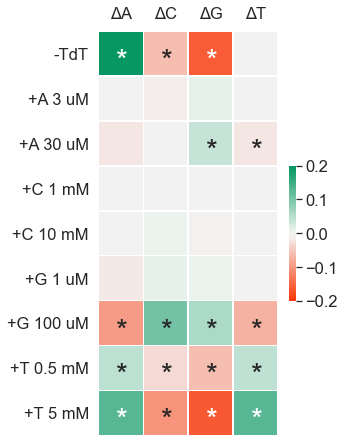

In [36]:
fig, ax = plt.subplots(figsize=(5,10))

sns.heatmap(heatmap_df, center=0, cmap=cmap, ax=ax, square=True, vmin=-.2, vmax=.2,
            annot=sig_df, fmt='', annot_kws={'fontsize': 30},
            cbar_kws={'shrink': .2, 'ticks': np.arange(-.2, .25, .1)},
            linewidths=.5, linecolor=None, )

for t in ax.texts:
    trans = t.get_transform()
    offs = matplotlib.transforms.ScaledTranslation(0, 0.2, matplotlib.transforms.IdentityTransform())
    t.set_transform(offs + trans)

ax.set_ylabel(None)
ax.set_yticklabels(['-TdT', '+A 3 uM', '+A 30 uM', '+C 1 mM', '+C 10 mM', '+G 1 uM', '+G 100 uM', '+T 0.5 mM', '+T 5 mM'], rotation=0)

ax.set_xlabel(None)
ax.set_xticklabels(['ΔA', 'ΔC', 'ΔG', 'ΔT'], rotation=0)

ax.tick_params(axis='both', which='major', labelbottom=False, labeltop=True)

plt.tight_layout()
plt.show()

fig.savefig(figure_dir + '/dNTP_change_heatmap.png')
fig.savefig(figure_dir + '/dNTP_change_heatmap.svg')

### Plot absolute compositions for each base

In [60]:
comp_df = pct_df.copy()
comp_df['Base Added'] = 'n/a'

comp_df.loc[((comp_df.Condition == 'dCF-dAdo')) \
           & ((comp_df.Concentration == '3 uM') | (comp_df.Concentration == '30 uM')), 'Base Added'] = 'A'
comp_df.loc[((comp_df.Condition == 'C')) \
           & ((comp_df.Concentration == '1 mM') | (comp_df.Concentration == '10 mM')), 'Base Added'] = 'C'
comp_df.loc[((comp_df.Condition == 'G')) \
           & ((comp_df.Concentration == '1 uM') | (comp_df.Concentration == '100 uM')), 'Base Added'] = 'G'
comp_df.loc[((comp_df.Condition == 'T')) \
           & ((comp_df.Concentration == '0.5 mM') | (comp_df.Concentration == '5 mM')), 'Base Added'] = 'T'
comp_df.loc[(comp_df.Condition == '-TdT'), 'Base Added'] = '-TdT'
comp_df.loc[(comp_df.Condition == 'none'), 'Base Added'] = '0'

order_dict = {'0 0': 0, '-TdT 0': 1, 'A 3 uM': 2, 'A 30 uM': 3, 'C 1 mM': 4, 'C 10 mM': 5, 'G 1 uM': 6, 'G 100 uM': 7,
              'T 0.5 mM': 8, 'T 5 mM': 9}

comp_df = comp_df.loc[comp_df['Base Added'] != 'n/a']
comp_df['Condition'] = comp_df['Base Added'] + ' ' + comp_df['Concentration']
comp_df = comp_df[['Condition', 'Replicate', 'A%', 'C%', 'G%', 'T%']]
comp_df = comp_df.sort_values(by='Condition', key=lambda x: x.map(order_dict)).reset_index(drop=True)
comp_df = comp_df.melt(id_vars=['Condition', 'Replicate'], var_name='Base')
comp_df

,Condition,Replicate,Base,value
0,0 0,1,A%,15.078719
1,0 0,2,A%,15.942854
2,0 0,3,A%,15.359198
3,-TdT 0,3,A%,38.655427
4,-TdT 0,1,A%,37.415882
...,...,...,...,...
111,T 0.5 mM,2,T%,15.273521
112,T 0.5 mM,1,T%,15.196811
113,T 5 mM,1,T%,23.566462
114,T 5 mM,2,T%,24.046851


In [82]:
palette = sns.color_palette(['lightsteelblue', 'salmon', 'mediumseagreen', 'khaki'])

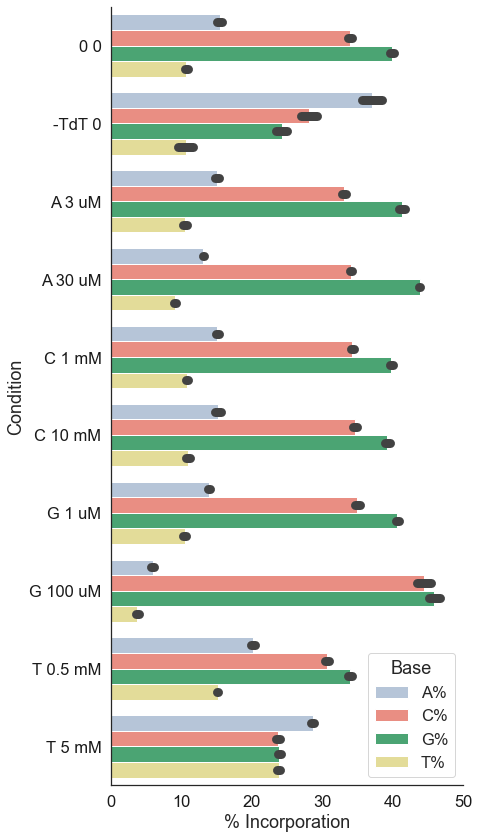

In [84]:
fig, ax = plt.subplots(figsize=(7, 12))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(color='0.6', labelcolor='k')

plt.xlim(0, 6)

ax.set_xticks(range(0, 51, 10))

sns.barplot(data=comp_df, x='value', y='Condition', hue='Base', #color='mediumseagreen',
            ci='sd', palette=palette)

plt.xlabel('% Incorporation')

plt.tight_layout()
plt.show()

fig.savefig(figure_dir + '/dNTP_comps.png')
fig.savefig(figure_dir + '/dNTP_comps.svg')

### Plot differences in insert lengths

In [85]:
len_df = pct_df.copy()
len_df['Base Added'] = 'n/a'

len_df.loc[((len_df.Condition == 'dCF-dAdo')) \
           & ((len_df.Concentration == '3 uM') | (len_df.Concentration == '30 uM')), 'Base Added'] = 'A'
len_df.loc[((len_df.Condition == 'C')) \
           & ((len_df.Concentration == '1 mM') | (len_df.Concentration == '10 mM')), 'Base Added'] = 'C'
len_df.loc[((len_df.Condition == 'G')) \
           & ((len_df.Concentration == '1 uM') | (len_df.Concentration == '100 uM')), 'Base Added'] = 'G'
len_df.loc[((len_df.Condition == 'T')) \
           & ((len_df.Concentration == '0.5 mM') | (len_df.Concentration == '5 mM')), 'Base Added'] = 'T'
len_df.loc[(len_df.Condition == '-TdT'), 'Base Added'] = '-TdT'
len_df.loc[(len_df.Condition == 'none'), 'Base Added'] = '0'

order_dict = {'0 0': 0, '-TdT 0': 1, 'A 3 uM': 2, 'A 30 uM': 3, 'C 1 mM': 4, 'C 10 mM': 5, 'G 1 uM': 6, 'G 100 uM': 7,
              'T 0.5 mM': 8, 'T 5 mM': 9}

len_df = len_df.loc[len_df['Base Added'] != 'n/a']
len_df['Condition'] = len_df['Base Added'] + ' ' + len_df['Concentration']
len_df = len_df[['Condition', 'Replicate', 'Mean Insert Length']]
len_df = len_df.sort_values(by='Condition', key=lambda x: x.map(order_dict)).reset_index(drop=True)
len_df

,Condition,Replicate,Mean Insert Length
0,0 0,1,3.223830
1,0 0,2,3.231806
2,0 0,3,3.204800
3,-TdT 0,3,1.630247
4,-TdT 0,1,1.919629
5,-TdT 0,2,1.972497
6,A 3 uM,3,3.144711
7,A 3 uM,2,3.156778
8,A 3 uM,1,3.135041
9,A 30 uM,2,3.040830


In [86]:
len_means = len_df.groupby('Condition').mean().drop('Replicate', axis=1)
len_means['Std'] = len_df.groupby('Condition').std()['Mean Insert Length']
len_means

,Mean Insert Length,Std
Condition,,
-TdT 0,1.840791,0.184242
0 0,3.220145,0.013875
A 3 uM,3.145510,0.010890
A 30 uM,3.036944,0.005495
C 1 mM,3.266312,0.027680
C 10 mM,3.503169,0.097300
G 1 uM,3.366191,0.040313
G 100 uM,3.313419,0.037578
T 0.5 mM,3.782415,0.067729


In [87]:
len_means.to_csv(figure_dir + '/length_means_and_stds.csv')

In [88]:
group0 = len_df.loc[len_df.Condition == '0 0']['Mean Insert Length']
mean0 = np.mean(group0)
std0 = np.std(group0)

len_pvals = {}

for cond in len_df.Condition.unique():
    if cond == '0 0':
        continue
    
    group1 = len_df.loc[len_df.Condition == cond]['Mean Insert Length']

    len_pvals[cond] = stats.ttest_ind(group0, group1)[1]

In [89]:
len_pvals

{'-TdT 0': 0.00020632647775027053,
 'A 3 uM': 0.0018445593705662983,
 'A 30 uM': 0.0004388333458547666,
 'C 1 mM': 0.06116090271454245,
 'C 10 mM': 0.0075558902420500606,
 'G 1 uM': 0.004045038391147118,
 'G 100 uM': 0.01569350546384203,
 'T 0.5 mM': 0.00014739927970751018,
 'T 5 mM': 2.2232534653848907e-08}

In [90]:
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
matplotlib.rc('axes', edgecolor='0.6')

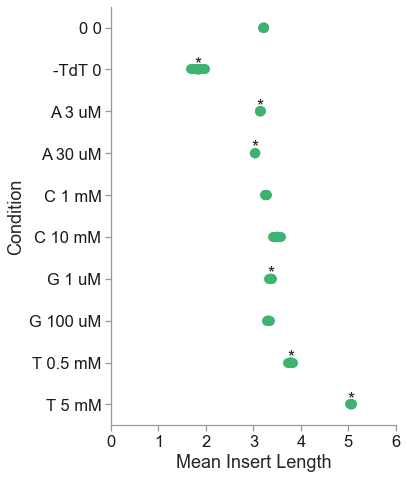

In [91]:
fig, ax = plt.subplots(figsize=(6, 7))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(color='0.6', labelcolor='k')

plt.xlim(0, 6)

ax.set_xticks([0, 1, 2, 3, 4, 5, 6])

sns.pointplot(data=len_df, x='Mean Insert Length', y='Condition', color='mediumseagreen',
              markers='o', linestyles='', scale=.36, errwidth=10, ci='sd')

for i, cond in enumerate(len_df.Condition.unique()):
    if cond == '0 0':
        continue
    
    pval = len_pvals[cond]
    if pval <= 0.05 / len(len_pvals):
        ax.text(x=np.mean(len_df.loc[len_df.Condition == cond]['Mean Insert Length']), y=i, s='*', ha='center')

plt.tight_layout()
plt.show()

fig.savefig(figure_dir + '/lengths_horizontal.png')
fig.savefig(figure_dir + '/lengths_horizontal.svg')

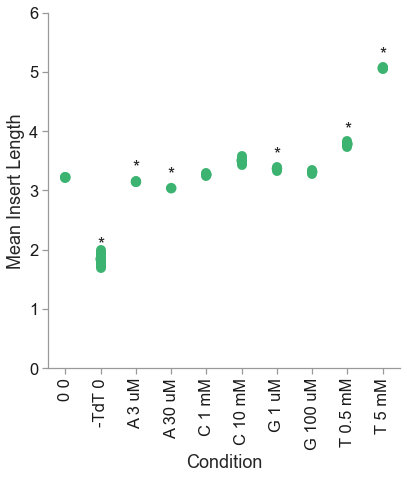

In [92]:
fig, ax = plt.subplots(figsize=(6, 7))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(color='0.6', labelcolor='k')

plt.ylim(0, 6)

ax.set_yticks([0, 1, 2, 3, 4, 5, 6])
plt.xticks(rotation=90)

sns.pointplot(data=len_df, y='Mean Insert Length', x='Condition', color='mediumseagreen',
              markers='o', linestyles='', scale=.36, errwidth=10, ci='sd')

for i, cond in enumerate(len_df.Condition.unique()):
    if cond == '0 0':
        continue
    
    pval = len_pvals[cond]
    if pval <= 0.05 / len(len_pvals):
        ax.text(y=np.mean(len_df.loc[len_df.Condition == cond]['Mean Insert Length']) + 0.15, x=i, s='*', ha='center')

plt.tight_layout()
plt.show()

fig.savefig(figure_dir + '/lengths_vertical.png')
fig.savefig(figure_dir + '/lengths_vertical.svg')

### Plot cutting efficiency

In [93]:
cut_df = summary_df[['TdT', 'Concentration', 'Condition', 'Replicate', '# Seqs', '# Cuts']]
cut_df['Base Added'] = 'n/a'

cut_df.loc[((cut_df.Condition == 'dCF-dAdo')) \
           & ((cut_df.Concentration == '3 uM') | (cut_df.Concentration == '30 uM')), 'Base Added'] = 'A'
cut_df.loc[((cut_df.Condition == 'C')) \
           & ((cut_df.Concentration == '1 mM') | (cut_df.Concentration == '10 mM')), 'Base Added'] = 'C'
cut_df.loc[((cut_df.Condition == 'G')) \
           & ((cut_df.Concentration == '1 uM') | (cut_df.Concentration == '100 uM')), 'Base Added'] = 'G'
cut_df.loc[((cut_df.Condition == 'T')) \
           & ((cut_df.Concentration == '0.5 mM') | (cut_df.Concentration == '5 mM')), 'Base Added'] = 'T'
cut_df.loc[(cut_df.Condition == '-TdT'), 'Base Added'] = '-TdT'
cut_df.loc[(cut_df.Condition == 'none'), 'Base Added'] = '0'

order_dict = {'0 0': 0, '-TdT 0': 1, 'A 3 uM': 2, 'A 30 uM': 3, 'C 1 mM': 4, 'C 10 mM': 5, 'G 1 uM': 6, 'G 100 uM': 7,
              'T 0.5 mM': 8, 'T 5 mM': 9}

cut_df = cut_df.loc[cut_df['Base Added'] != 'n/a']
cut_df['Condition'] = cut_df['Base Added'] + ' ' + cut_df['Concentration']
cut_df = cut_df.loc[:, ['Condition', 'Replicate', '# Seqs', '# Cuts']]
cut_df = cut_df.sort_values(by='Condition', key=lambda x: x.map(order_dict)).reset_index(drop=True)
cut_df['% Reads with Additions'] = 100 * cut_df['# Cuts'] / cut_df['# Seqs']

cut_df

<ipython-input-93-6a26cf07bbca>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_df['Base Added'] = 'n/a'
/home/jonstrutz/anaconda3/envs/turtles/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


,Condition,Replicate,# Seqs,# Cuts,% Reads with Additions
0,0 0,1,180144,35031,19.446110
1,0 0,2,168750,34805,20.625185
2,0 0,3,136204,24458,17.956888
3,-TdT 0,3,272976,14699,5.384722
4,-TdT 0,1,263460,14321,5.435740
5,-TdT 0,2,267705,13962,5.215442
6,A 3 uM,3,135683,16495,12.157013
7,A 3 uM,2,183779,23039,12.536253
8,A 3 uM,1,152687,20890,13.681584
9,A 30 uM,2,297342,36836,12.388428


In [94]:
cut_df.to_csv(figure_dir + '/pct_reads_w_additions.csv')

In [95]:
cut_df_stats = cut_df.groupby('Condition').mean().drop('Replicate', axis=1)
cut_df_stats['% Reads with Additions Std'] = cut_df.groupby('Condition').std()['% Reads with Additions']
cut_df_stats

,# Seqs,# Cuts,% Reads with Additions,% Reads with Additions Std
Condition,,,,
-TdT 0,268047.000000,14327.333333,5.345302,0.115318
0 0,161699.333333,31431.333333,19.342728,1.337149
A 3 uM,157383.000000,20141.333333,12.791617,0.793717
A 30 uM,221419.000000,28173.500000,12.899209,0.722354
C 1 mM,176401.000000,38280.000000,21.724756,1.008232
C 10 mM,141732.666667,32497.666667,22.927220,1.102518
G 1 uM,168548.666667,23387.666667,13.855846,0.453191
G 100 uM,124813.000000,16769.000000,13.449953,0.956348
T 0.5 mM,156588.333333,42500.666667,27.102987,0.282689


In [96]:
cut_df_stats.to_csv(figure_dir + '/pct_reads_w_additions_stats.csv')

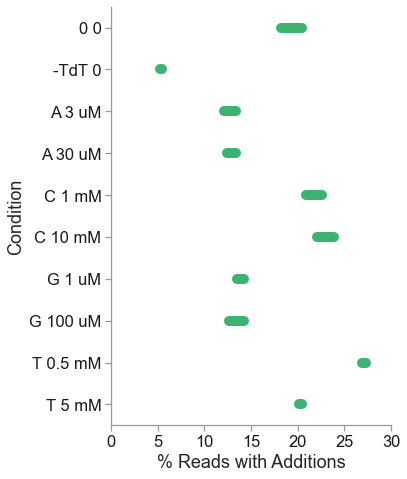

In [97]:
fig, ax = plt.subplots(figsize=(6, 7))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(color='0.6', labelcolor='k')

plt.xlim(0, 30)

ax.set_xticks([0, 5, 10, 15, 20, 25, 30])

sns.pointplot(data=cut_df, x='% Reads with Additions', y='Condition', color='mediumseagreen',
              markers='', linestyles='', scale=.34, errwidth=10, ci='sd')

plt.tight_layout()
plt.show()

fig.savefig(figure_dir + '/pct_additions.png')
fig.savefig(figure_dir + '/pct_additions.svg')